In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from scipy import stats

# Loading Data

In [2]:
df = pd.read_csv('./data/icu_ibd_all_table.csv')
df['intime'] = pd.to_datetime(df['intime'])
df.shape

(1161, 32)

In [3]:
df2 = pd.read_csv('./data/patients_ibd.csv')

func = lambda x: pd.to_datetime('{}-01-01'.format(x))
df2['anchor_year'] = df2['anchor_year'].apply(func)

df2.shape

(2417, 6)

# Preprocess Data

## Make a Combination

In [4]:
data = df.merge(df2[['subject_id', 'anchor_year']], on='subject_id', how='left')
data.sort_values(by=['subject_id', 'intime'], inplace=True)
data['age'] = ((data['intime'] - data['anchor_year']).dt.days) / 365 + data['age']

## Checking Missing Value

In [5]:
# 检查缺失值
cols_missing = []

for col in data.columns:
    if data[col].isna().sum() / data.shape[0]*100 > 5:
        cols_missing.append(col)
        print(f'{col}:\n  NA count: {data[col].isna().sum()} ({data[col].isna().sum() / data.shape[0]*100:.2f}%)\n')

weight:
  NA count: 1066 (91.82%)

bmi:
  NA count: 1070 (92.16%)

systolic_pressure:
  NA count: 1099 (94.66%)

diastolic_pressure:
  NA count: 1099 (94.66%)

temperature:
  NA count: 962 (82.86%)

white_blood_cell:
  NA count: 1155 (99.48%)

red_blood_cell:
  NA count: 705 (60.72%)

CRP:
  NA count: 1161 (100.00%)



## Delete Useless Columns

In [6]:
# 删除不需要的列

cols_useless = [
    'hadm_id',
    'intime',
    'outtime',
    'mortality',
    'die_in_icu',
    'anchor_year',
]

cols_except = cols_missing + cols_useless


data.drop(columns=cols_except, inplace=True)

In [7]:
print(data.columns)

Index(['subject_id', 'los', 'gender', 'age', 'heart_rate', 'respiratory_rate',
       'hematocrit', 'rdw', 'platelet', 'mcv', 'mch', 'hemoglobin', 'race',
       'language', 'marital_status', 'insurance', 'uc_only', 'cd_only',
       'uc_cd'],
      dtype='object')


## Keeping One ICU Record for Each Patient

In [8]:
data = data[~(data.isna().sum(axis=1) > (data.shape[1]+1)*0.05)]

# 只保留每个病人的第一次 ICU 记录
data.drop_duplicates(subset='subject_id', keep='first', inplace=True)

In [9]:
print(data.subject_id.unique().shape)

(652,)


## Formatting Race

In [10]:
def parse_race(race):
    if 'WHITE' in race:
        return 'WHITE'
    elif 'BLACK' in race:
        return 'BLACK'
    elif 'HISPANIC' in race or 'LATINO' in race:
        return 'HISPANIC/LATINO'
    elif 'ASIAN' in race:
        return 'ASIAN'
    else:
        return 'OTHER'


data.loc[:, 'race'] = data.loc[:, 'race'].apply(parse_race)

In [11]:
data.drop(columns=['subject_id', 'uc_cd'], inplace=True)

# Data Preparation

## Formatting Dummy Variables

In [12]:
# # 处理 dummy variables
# cols = ['language', 'race', 'marital_status', 'insurance']

# for col in cols:
#     tmp = data[col].value_counts()
#     res = pd.DataFrame({'index': tmp.index, 'count': tmp.values, 'percentage': tmp.values/tmp.sum()*100})
#     print(f'{res.set_index("index")}')
#     print()
    

# data = pd.get_dummies(data=data, 
#                       columns=cols, 
#                       prefix=cols, 
#                       drop_first=True)

# data.columns

## Standalization

In [13]:
# cols = ['age', 'heart_rate', 'respiratory_rate', 'hematocrit', 'rdw', 'platelet', 'mcv', 'mch', 'hemoglobin',]

# scaler = StandardScaler()

# scaler = MinMaxScaler()

# data[cols] = scaler.fit_transform(data[cols])

In [14]:
# 转换所有 bool 类型为 int
# for k, v in data.dtypes.items():
#     if v == bool:
#         data.loc[:, k] = data.loc[:, k].astype(int)

## Export Data

In [15]:
## data['los'] = np.log(data['los'] + 1)

# data.to_csv('./data.csv')

# Statistcal Test

In [16]:
data.columns

Index(['los', 'gender', 'age', 'heart_rate', 'respiratory_rate', 'hematocrit',
       'rdw', 'platelet', 'mcv', 'mch', 'hemoglobin', 'race', 'language',
       'marital_status', 'insurance', 'uc_only', 'cd_only'],
      dtype='object')

## LOS

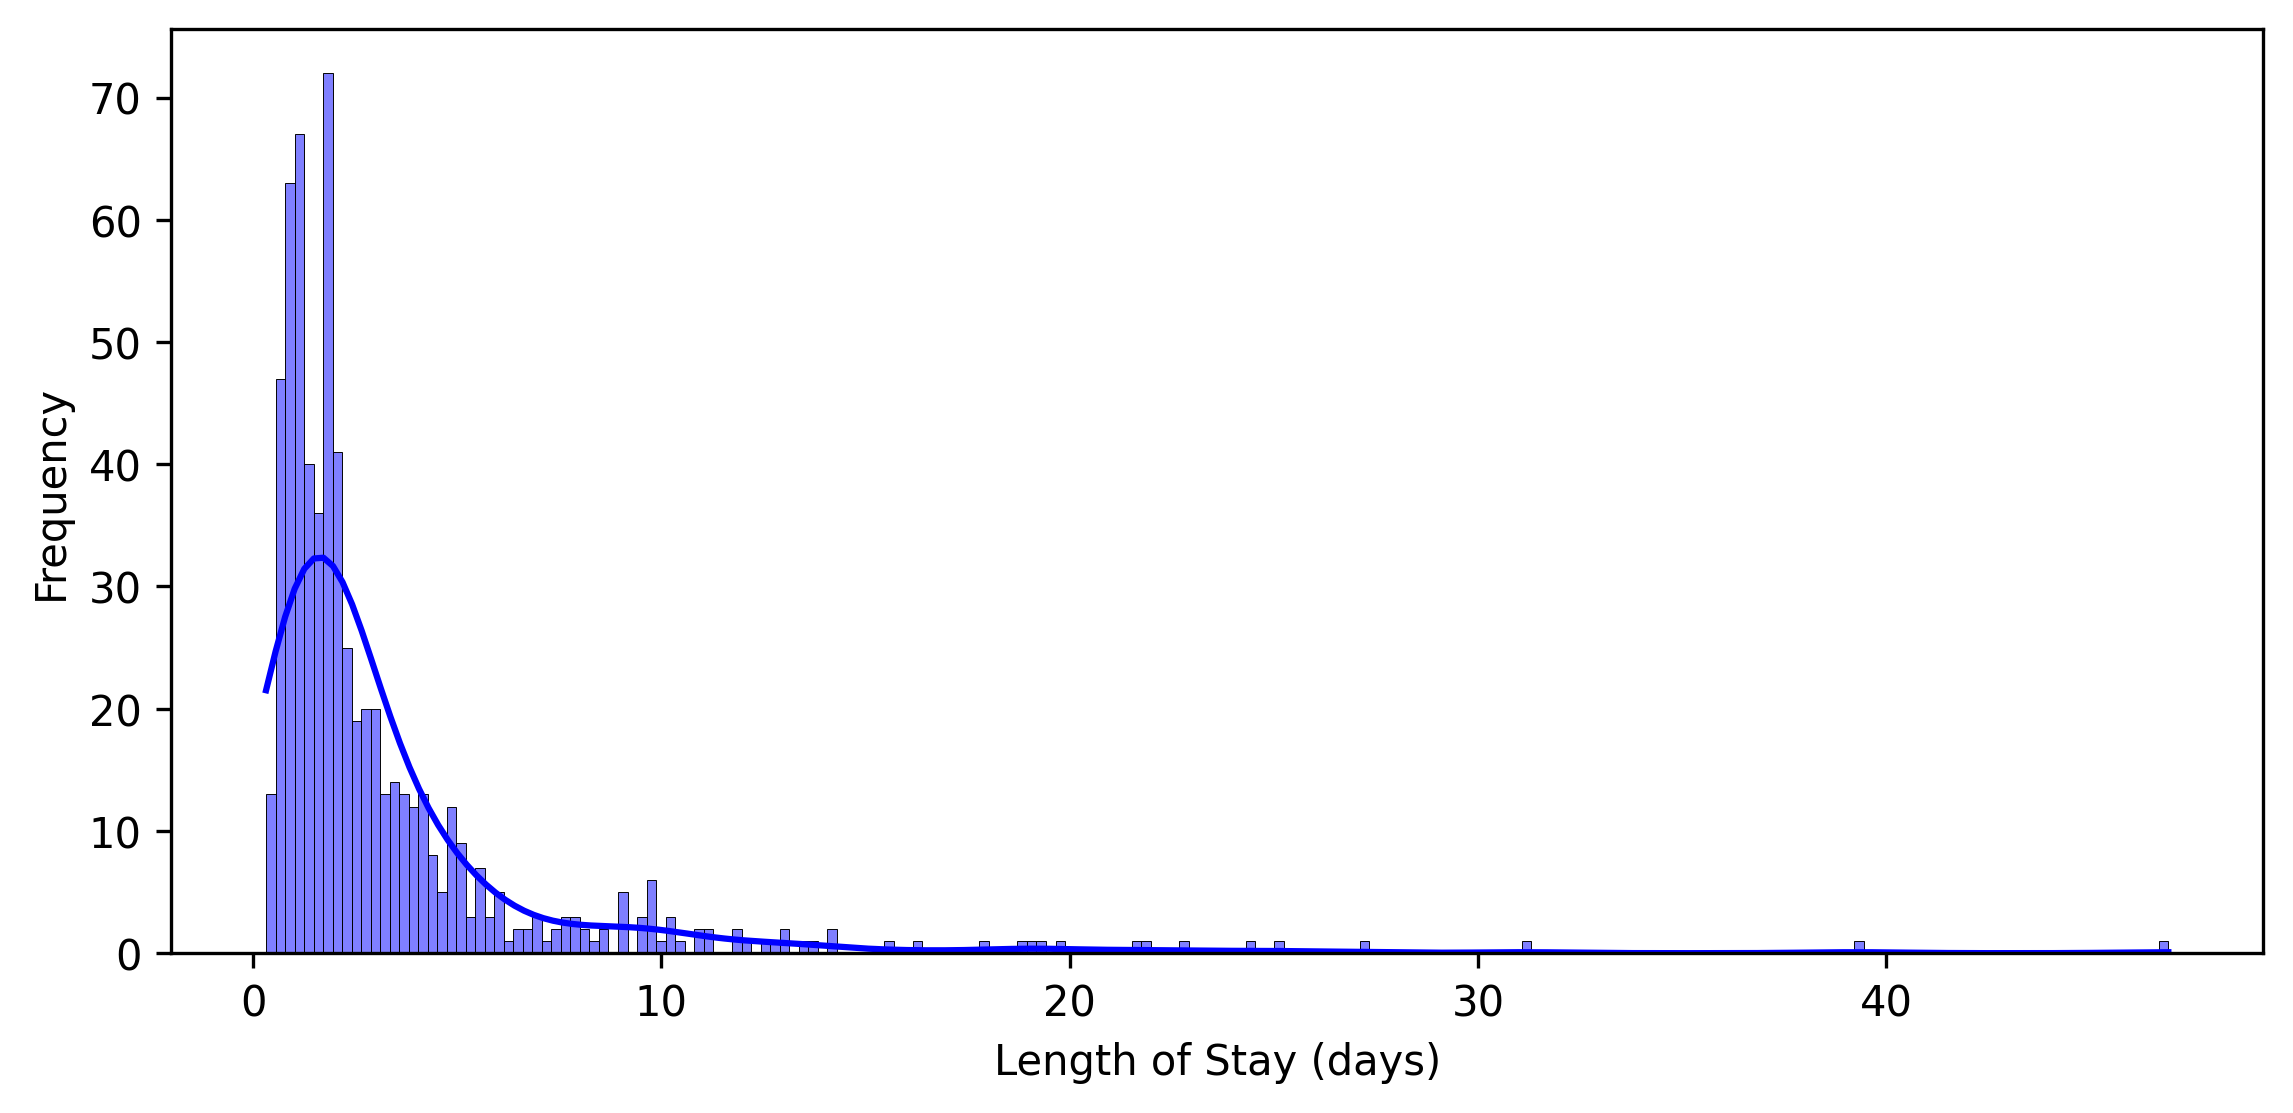

In [25]:
# 设置seaborn的风格
# sns.set(style="whitegrid")

# 绘制直方图，可以通过调整bins的数量、颜色等参数来美化图表
# kde参数为True会添加一个核密度估计（KDE）线
plt.figure(figsize=(9,4), dpi=300)
sns.histplot(data.los, bins=200, color="blue", kde=True)

# 添加标题和标签
plt.xlabel('Length of Stay (days)')
plt.ylabel('Frequency')

# 显示图表
plt.show()

## 'age', 'heart_rate', 'respiratory_rate', 'hematocrit', 'rdw', 'platelet','mcv', 'mch', 'hemoglobin'

In [18]:
data['los_'] = (data.los <= 4).astype(int)

for col in ['age', 'heart_rate', 'respiratory_rate', 'hematocrit', 'rdw', 'platelet','mcv', 'mch', 'hemoglobin']:
    x1 = data.loc[data.los_ == 0, col]
    x2 = data.loc[data.los_ == 1, col]
    
    x1 = np.array(x1)
    x2 = np.array(x2)
    
    # U-statistics
    u_statistic, u_p_value = stats.mannwhitneyu(x1, x2, alternative='two-sided')
    
    # t-statistics
    t_statistic, t_p_value = stats.ttest_ind(x1, x2, equal_var=False)
    
    print(f'{col}\n  los=0: ({x1.mean():.2f}, {x1.std():.2f}) los=1: ({x2.mean():.2f}, {x2.std():.2f})')
    print(f'    u-statistic: {u_statistic:.4f} p: {u_p_value:.4f} significant: {u_p_value < 0.05}')
    print(f'    t-statistic: {t_statistic:.4f} p: {t_p_value:.4f} significant: {t_p_value < 0.05}')
    print()

age
  los=0: (62.91, 15.26) los=1: (62.39, 16.94)
    u-statistic: 36357.0000 p: 0.8672 significant: False
    t-statistic: 0.3468 p: 0.7291 significant: False

heart_rate
  los=0: (91.90, 19.09) los=1: (87.94, 19.78)
    u-statistic: 40708.0000 p: 0.0180 significant: True
    t-statistic: 2.1576 p: 0.0320 significant: True

respiratory_rate
  los=0: (21.06, 5.83) los=1: (18.92, 5.82)
    u-statistic: 44489.0000 p: 0.0000 significant: True
    t-statistic: 3.8556 p: 0.0002 significant: True

hematocrit
  los=0: (30.19, 5.51) los=1: (30.99, 6.00)
    u-statistic: 33573.5000 p: 0.2157 significant: False
    t-statistic: -1.4972 p: 0.1357 significant: False

rdw
  los=0: (15.97, 2.60) los=1: (15.48, 2.36)
    u-statistic: 39356.0000 p: 0.0926 significant: False
    t-statistic: 2.0127 p: 0.0454 significant: True

platelet
  los=0: (241.13, 155.21) los=1: (nan, nan)
    u-statistic: nan p: nan significant: False
    t-statistic: nan p: nan significant: False

mcv
  los=0: (91.13, 8.12) los

## 'race', 'language', 'marital_status', 'insurance'

In [19]:
data['type'] = data.loc[:, ['uc_only', 'cd_only']].apply(lambda x: x.iloc[0] + 2*x.iloc[1], axis=1)

In [20]:
columns = ['type']

for index in ['race', 'language', 'marital_status', 'insurance']:
    res = pd.pivot_table(
        data=data,
        values='los',
        index=index,
        columns=columns,
        aggfunc=['mean', 'std', 'count']
    )

    print(res)

                     mean                           std                      \
type                    0         1         2         0         1         2   
race                                                                          
ASIAN            1.108660  5.652757  3.074340       NaN  3.581111       NaN   
BLACK            1.508489  3.768722  2.086715  1.192283  6.088566  1.666521   
HISPANIC/LATINO  1.191420  2.556713  3.907187       NaN  1.642190  4.159725   
OTHER            2.508280  2.959220  4.168294  1.178761  2.972864  4.351154   
WHITE            3.298588  3.319089  3.240548  3.168231  5.068688  3.803972   

                count            
type                0    1    2  
race                             
ASIAN               1    3    1  
BLACK               2   27   16  
HISPANIC/LATINO     1    6    8  
OTHER               2   26   25  
WHITE              28  254  252  
              mean                           std                     count  \
type             

### Race

In [21]:
# Race
mean_los = (
    data.groupby(['race', 'type'])
    .agg({'los': 'mean'})
    .reset_index()
)

mean_los

,race,type,los
0,ASIAN,0,1.108660
1,ASIAN,1,5.652757
2,ASIAN,2,3.074340
3,BLACK,0,1.508489
4,BLACK,1,3.768722
5,BLACK,2,2.086715
6,HISPANIC/LATINO,0,1.191420
7,HISPANIC/LATINO,1,2.556713
8,HISPANIC/LATINO,2,3.907187
9,OTHER,0,2.508280


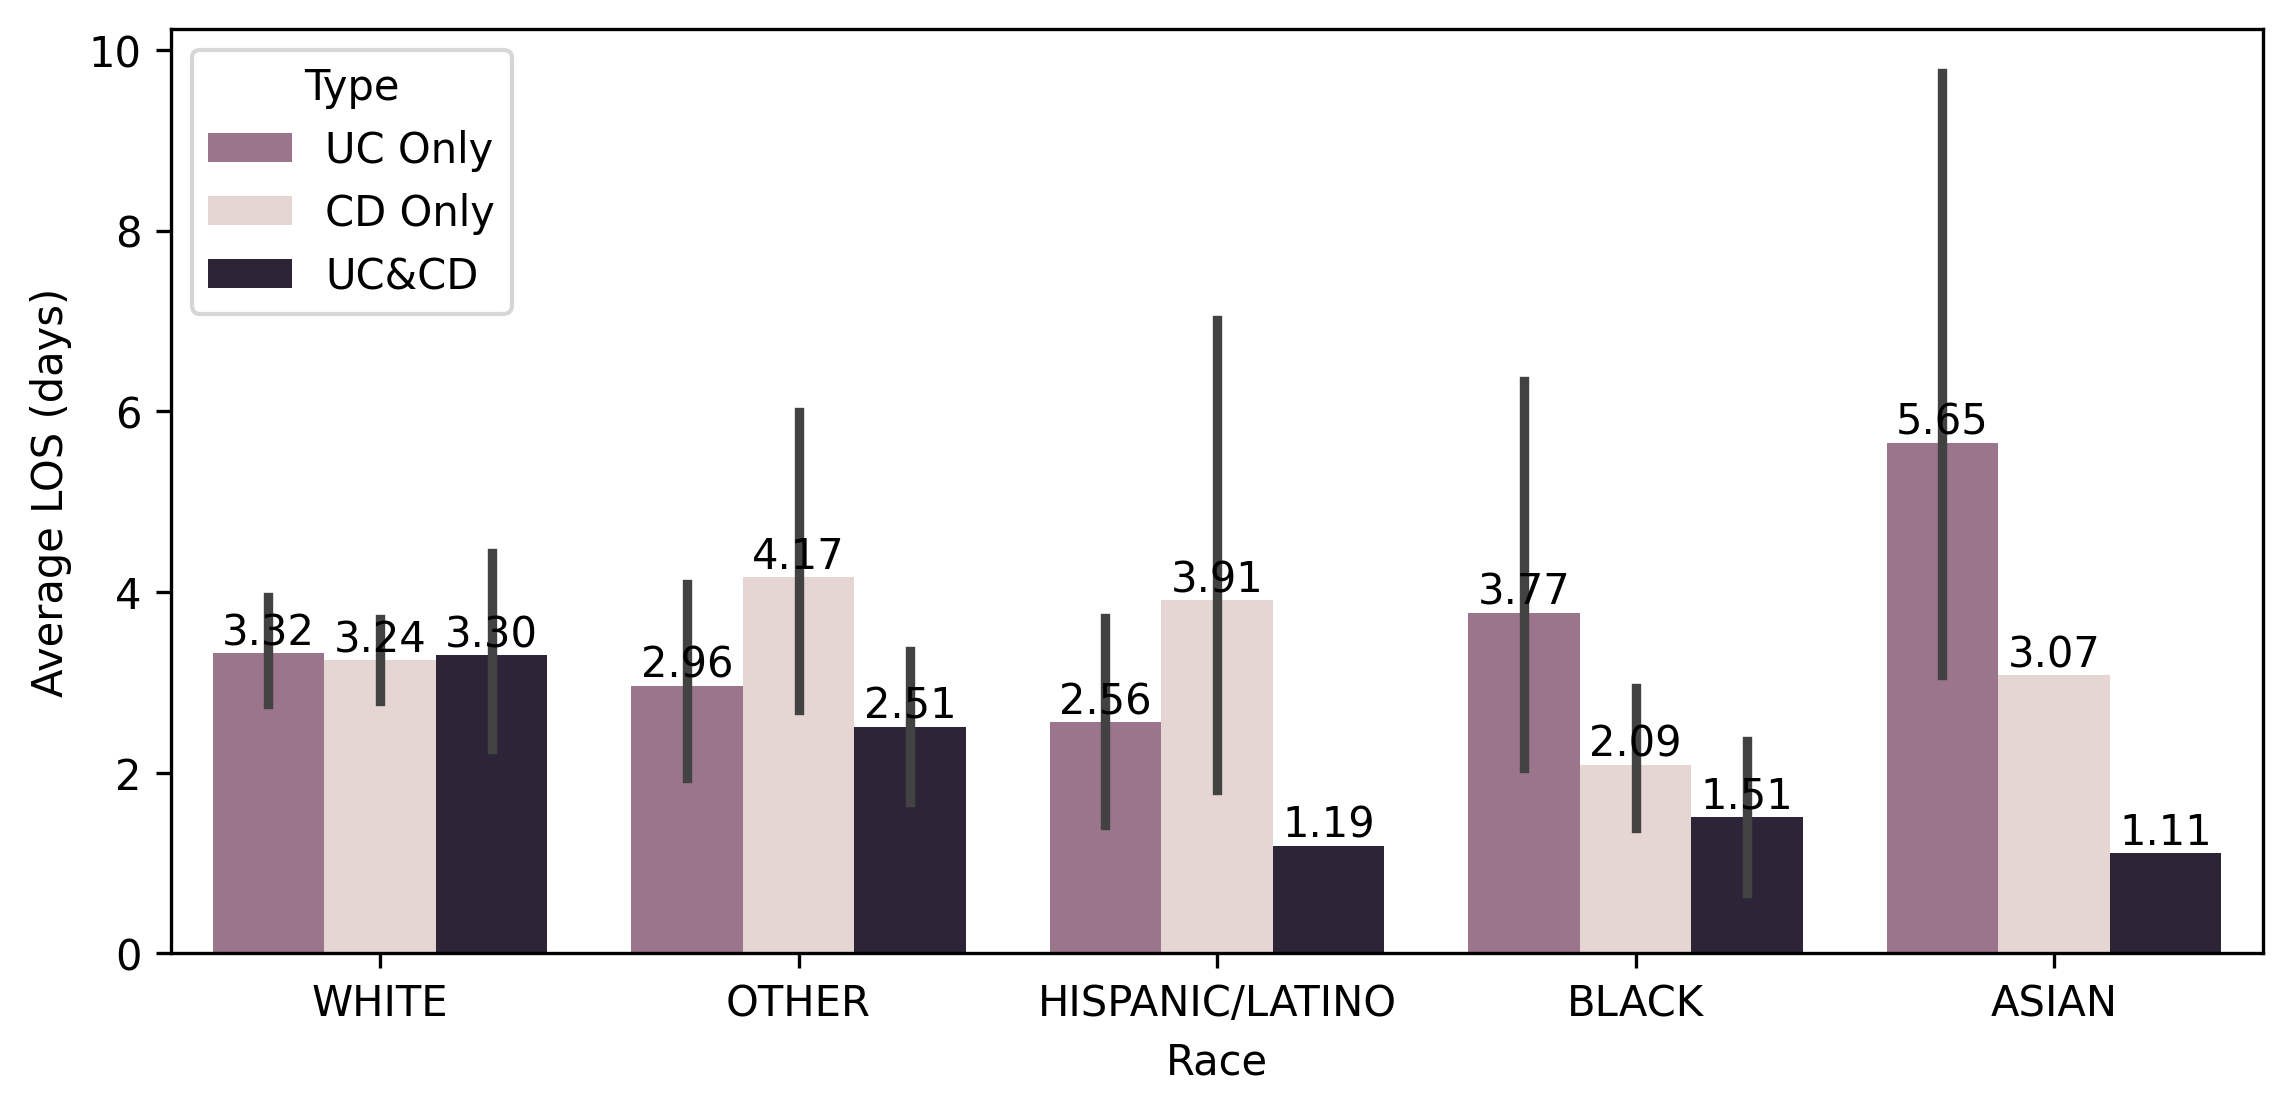

In [24]:
plt.figure(figsize=(9, 4), dpi=300)

data['hue'] = data.type.apply(lambda x: {0: 'UC&CD', 1: 'UC Only', 2: 'CD Only'}[x])

color_mapping = {
    'UC&CD': (0.17638493922735704, 0.13387019035781797, 0.2266899340897154, 1),
    'UC Only': (0.6301710208255752, 0.4352806634991918, 0.5531285070707633, 1),
    'CD Only': (0.9145040817242649, 0.8311962996810209, 0.8139132380746315, 1),
}

ax = sns.barplot(data=data, 
                 x='race',
                 y='los', 
                 hue='hue', 
                 palette=color_mapping,
                 legend=True)

# 在每个条上显示值
for p in ax.patches:
    if p.get_height() > 0:
        ax.text(p.get_x() + p.get_width() / 2.,  # x位置
                p.get_height(),  # y位置
                '{:1.2f}'.format(p.get_height()),  # 文本
                ha='center',  # 水平居中
                va='bottom')  # 垂直底部


# 设置图表的其他属性
plt.xlabel('Race')
plt.ylabel('Average LOS (days)')
plt.legend(title='Type')
plt.show()